In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

import scipy  # for io.mmread

#from os import listdir
import glob
import os
import re
import seaborn

In [2]:
# Download data
# cd /lustre/scratch126/cellgen/team205/sk29/matthias_fb/data/external/martin19_raw
# wget -O GSE134809_RAW.tar "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE134809&format=file"
# tar -xvkf GSE134809_RAW.tar

# Parse raw counts matrices

In [3]:
# List of downloaded files
file_paths = glob.glob("../data/external/martin19_raw/*_matrix.mtx.gz")

In [4]:
# file basenames
file_base = [os.path.basename(f) for f in file_paths]
file_base

['GSM3972009_69_matrix.mtx.gz',
 'GSM3972021_186_matrix.mtx.gz',
 'GSM3972020_181_matrix.mtx.gz',
 'GSM3972025_192_matrix.mtx.gz',
 'GSM3972017_158_matrix.mtx.gz',
 'GSM3972019_180_matrix.mtx.gz',
 'GSM3972011_122_matrix.mtx.gz',
 'GSM3972029_208_matrix.mtx.gz',
 'GSM4761139_134_matrix.mtx.gz',
 'GSM4761144_194_matrix.mtx.gz',
 'GSM3972018_159_matrix.mtx.gz',
 'GSM4761140_157_matrix.mtx.gz',
 'GSM3972022_187_matrix.mtx.gz',
 'GSM4761137_126_matrix.mtx.gz',
 'GSM3972026_193_matrix.mtx.gz',
 'GSM3972016_138_matrix.mtx.gz',
 'GSM4761141_179_matrix.mtx.gz',
 'GSM3972027_195_matrix.mtx.gz',
 'GSM4761138_127_matrix.mtx.gz',
 'GSM4761142_185_matrix.mtx.gz',
 'GSM3972014_129_matrix.mtx.gz',
 'GSM3972012_123_matrix.mtx.gz',
 'GSM4761143_191_matrix.mtx.gz',
 'GSM3972013_128_matrix.mtx.gz',
 'GSM3972030_209_matrix.mtx.gz',
 'GSM3972015_135_matrix.mtx.gz',
 'GSM3972023_189_matrix.mtx.gz',
 'GSM3972028_196_matrix.mtx.gz',
 'GSM3972024_190_matrix.mtx.gz',
 'GSM4761136_67_matrix.mtx.gz',
 'GSM3972010

In [5]:
# Get GEO IDs from file names
geo_ids = [re.search("^(.+_.+)_", x).group(1) for x in file_base]
geo_ids

['GSM3972009_69',
 'GSM3972021_186',
 'GSM3972020_181',
 'GSM3972025_192',
 'GSM3972017_158',
 'GSM3972019_180',
 'GSM3972011_122',
 'GSM3972029_208',
 'GSM4761139_134',
 'GSM4761144_194',
 'GSM3972018_159',
 'GSM4761140_157',
 'GSM3972022_187',
 'GSM4761137_126',
 'GSM3972026_193',
 'GSM3972016_138',
 'GSM4761141_179',
 'GSM3972027_195',
 'GSM4761138_127',
 'GSM4761142_185',
 'GSM3972014_129',
 'GSM3972012_123',
 'GSM4761143_191',
 'GSM3972013_128',
 'GSM3972030_209',
 'GSM3972015_135',
 'GSM3972023_189',
 'GSM3972028_196',
 'GSM3972024_190',
 'GSM4761136_67',
 'GSM3972010_68']

In [6]:
# Reads and parses matrix and annotations. Returns AnnData object.
def parseCountMatrix(geo_id, data_path):
    print(geo_id)
    # Load CellRanger sparse gene count matrix
    mat = scipy.io.mmread(data_path + geo_id + "_matrix.mtx.gz")
    
    # Load gene information
    genes = pd.read_table(data_path + geo_id + "_genes.tsv.gz", header=None)
    genes.columns = ['gene_ids', 'gene_symbol']
    genes.index = genes.gene_ids

    # Load barcodes
    cells = pd.read_table(data_path + geo_id + "_barcodes.tsv.gz", header=None)
    cells.columns = ['barcode']
    cells['sample_id'] = geo_id.split('_')[1]
    
    # Convert to AnnData object
    adata = sc.AnnData(X=mat.transpose(), obs=cells, var=genes, dtype=np.float32)
    
    # cell index
    adata.obs.index = adata.obs.barcode.astype(str) + '-' + adata.obs.sample_id.astype(str)
    
    return(adata)

In [7]:
# Load and parse files per patient sample
data_path = "../data/external/martin19_raw/"
adatas = [parseCountMatrix(geo_id=x, data_path=data_path) for x in geo_ids]

GSM3972009_69


/home/jovyan/my-conda-envs/ni_env2/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


GSM3972021_186
GSM3972020_181
GSM3972025_192
GSM3972017_158
GSM3972019_180
GSM3972011_122
GSM3972029_208
GSM4761139_134
GSM4761144_194
GSM3972018_159
GSM4761140_157
GSM3972022_187
GSM4761137_126
GSM3972026_193
GSM3972016_138
GSM4761141_179
GSM3972027_195
GSM4761138_127
GSM4761142_185
GSM3972014_129
GSM3972012_123
GSM4761143_191
GSM3972013_128
GSM3972030_209
GSM3972015_135
GSM3972023_189
GSM3972028_196
GSM3972024_190
GSM4761136_67
GSM3972010_68


In [8]:
# Print data dimensions
[x.shape for x in adatas]

[(737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694),
 (737280, 33694)]

In [9]:
# Merge data across samples
adata = sc.concat(adatas)

# left join gene data, assumes identical transcripts
adata.var = adata.var.join(adatas[0].var)

In [10]:
# remove empty cells in place
sc.pp.filter_cells(adata, min_counts=1)

In [11]:
adata

AnnData object with n_obs × n_vars = 5982179 × 33694
    obs: 'barcode', 'sample_id', 'n_counts'
    var: 'gene_ids', 'gene_symbol'

In [12]:
adata.obs

,barcode,sample_id,n_counts
AAACATACAAAACG-1-69,AAACATACAAAACG-1,69,10.0
AAACATACAAAAGC-1-69,AAACATACAAAAGC-1,69,3.0
AAACATACAACAGA-1-69,AAACATACAACAGA-1,69,2.0
AAACATACAACCAC-1-69,AAACATACAACCAC-1,69,10.0
AAACATACAACCTG-1-69,AAACATACAACCTG-1,69,549.0
...,...,...,...
TTTGCATGTTTCGT-1-68,TTTGCATGTTTCGT-1,68,972.0
TTTGCATGTTTCTG-1-68,TTTGCATGTTTCTG-1,68,1.0
TTTGCATGTTTGCT-1-68,TTTGCATGTTTGCT-1,68,1585.0
TTTGCATGTTTGGG-1-68,TTTGCATGTTTGGG-1,68,7.0


In [13]:
# Print counts per sample ID
adata.obs.sample_id.value_counts()

191    338172
192    271937
193    267531
181    265969
190    249350
158    245123
189    235850
180    231410
179    231164
68     227537
159    225606
185    223498
195    213634
196    209719
194    194746
186    194421
209    186538
208    184478
135    176571
138    175368
128    166092
69     163408
157    153210
123    152556
129    136464
134    124524
187    121561
122    113837
126    105562
127    103499
67      92844
Name: sample_id, dtype: int64

# Merge cell annotations from Rasa

In [14]:
# Load annotations from Rasa, merge into raw count AnnData object
adata_annot = sc.read_h5ad("/nfs/team205/re5/data/martin19_all.processed.cellxgene_for_rasa.h5ad")

In [15]:
adata_annot

AnnData object with n_obs × n_vars = 57905 × 33694
    obs: 'sample_id', 'lesion', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'annot', 'joint_annot', 'broad_annot', 'pedgut_annot', 'pedgut_annot_prob', 'fetalgut_annot', 'fetalgut_annot_prob'
    var: 'gene_ids', 'mito', 'ribo', 'hb'
    obsm: 'X_umap'

In [16]:
# Strip last '-nonL' and '-L' from cell barcodes
new_index = [re.search("^(.+)-.+$", x).group(1) for x in adata_annot.obs.index]
adata_annot.obs.index = new_index

In [17]:
# Append cell annotations
adata.obs = adata.obs.join(adata_annot.obs, rsuffix='_annot')

In [18]:
adata

AnnData object with n_obs × n_vars = 5982179 × 33694
    obs: 'barcode', 'sample_id', 'n_counts', 'sample_id_annot', 'lesion', 'n_counts_annot', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'annot', 'joint_annot', 'broad_annot', 'pedgut_annot', 'pedgut_annot_prob', 'fetalgut_annot', 'fetalgut_annot_prob'
    var: 'gene_ids', 'gene_symbol'

In [19]:
adata.obs.joint_annot.value_counts()

T CD4               11777
Plasma IgM          10208
T CD8 mem            6044
T CD4 naive          5450
B mem                3431
B naive              3351
Plasma IgG           2412
T CD8 exhausted      1683
T reg                1531
ILC                  1341
EC                   1232
LC                    907
NK                    730
S1                    724
nrMac                 664
rMac                  649
EC progenitor         450
rMac activated 1      430
T CD8 naive           396
T cycling             347
Goblet                336
VE tip                329
aDC                   317
S3                    221
Glial                 221
VE art                199
rMac activated 2      199
VE cap                193
LE                    187
VE ven                186
DC1                   175
S5x                   173
Pericyte              171
Mono                  149
S5                    136
Plasmablast           135
Epi cycling           124
Mast                  119
pDC         

In [20]:
# Filter out cells without annotations. Includes QC from previous analysis.
adata = adata[~adata.obs.joint_annot.isna()]

# Check if dimensions match indicating whether all barcodes have been found
assert(adata_annot.shape[0] == adata.shape[0])

<AxesSubplot: xlabel='n_counts', ylabel='n_counts_annot'>

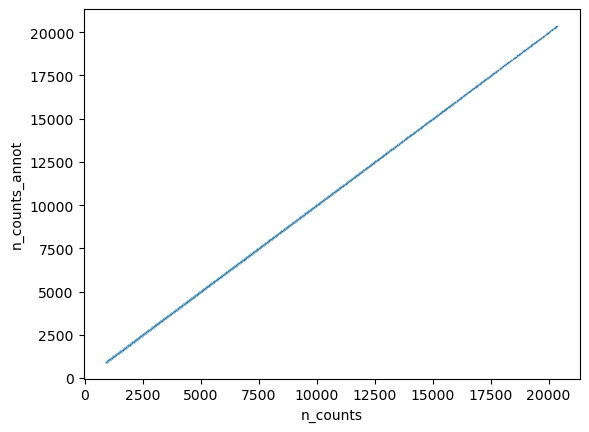

In [21]:
# Plot exact matches of gene counts per cell. Expects diagonal line y=x.
seaborn.scatterplot(data=adata.obs, x='n_counts', y='n_counts_annot', s=1)

In [22]:
# Set gene index as gene symbols -- does not work for some reason
#adata.var_index = adata.var.gene_symbol
#adata.var_index = adata.var.gene_symbol.astype(str)
#adata.var_names_make_unique()

In [23]:
# Write raw data with annotations
adata.write_h5ad("../data/external/martin19_raw/martin19_all.raw.annot.h5ad")

/home/jovyan/my-conda-envs/ni_env2/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/jovyan/my-conda-envs/ni_env2/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/jovyan/my-conda-envs/ni_env2/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


In [24]:
# clean up intermediate files from GEO repository download
# cd /lustre/scratch126/cellgen/team205/sk29/matthias_fb/data/external/martin19_raw
# rm *.tsv.gz *.mtx.gz